In [285]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchmetrics.classification import BinaryConfusionMatrix

import tqdm

import copy

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, confusion_matrix,
                             precision_score, recall_score)

import torch.utils.data as data_utils

In [230]:
device = torch.device("cuda:0")

## Read in data 

In [231]:
train = np.load('/content/baseline_train_smote.npz')
#train = np.load("/content/baseline_train.npz")

In [232]:
train["x"].shape

(1511688, 106)

In [233]:
train["y"].shape

(1511688,)

In [236]:
validation = np.load('/content/baseline_validation_smote.npz')
#validation = np.load('/content/baseline_validation.npz')

In [237]:
validation["x"].shape

(322886, 106)

In [238]:
validation["y"].shape

(322886,)

In [239]:
test = np.load("/content/baseline_test_smote.npz")
#test = np.load("/content/baseline_test.npz")

In [240]:
test["x"].shape 

(323748, 106)

In [241]:
test["y"].shape

(323748,)

In [242]:
unique_labels, label_counts = np.unique(train["y"], return_counts=True)
print(f"Count of negative vs positive labels: {label_counts}")

Count of negative vs positive labels: [755844 755844]


In [78]:
231/755844

0.0003056186197151793

In [69]:
class_weights = [sum(label_counts)/c for c in label_counts]
class_weights 

[1.0003056186197152, 3273.051948051948]

In [182]:
# Assign weights to samples 
sample_weights = [class_weights[int(l)] for l in train["y"]]
sampler = WeightedRandomSampler(sample_weights, len(train["y"]))

In [248]:
# Load data 
minibatch_size = 500

X_train = torch.tensor(train["x"], dtype=torch.float32).to(device)
y_train = torch.tensor(train["y"], dtype=torch.float32).reshape(-1,1).to(device)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=minibatch_size, 
                                           shuffle=True) 
#train_loader = torch.utils.data.DataLoader(train_dataset, 
#                                           batch_size=minibatch_size, 
#                                           sampler=sampler,
#                                           shuffle=False)

X_val = torch.tensor(validation["x"], dtype=torch.float32).to(device)
y_val = torch.tensor(validation["y"], dtype=torch.float32).reshape(-1,1).to(device)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

X_test = torch.tensor(test["x"], dtype=torch.float32).to(device)
y_test = torch.tensor(test["y"], dtype=torch.float32).reshape(-1,1).to(device)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model setup 

In [249]:
class FF1(nn.Module):
    def __init__(self, input_size, hl1, hl2):
        super().__init__()
        self.hl1 = nn.Linear(input_size, hl1)
        self.hl2 = nn.Linear(hl1, hl2)
        self.output = nn.Linear(hl2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hl1(x))
        x = self.relu(self.hl2(x))
        x = self.sigmoid(self.output(x))

        return x

In [250]:
# Initialize model 
input_size = 106
hl1 = 66 
hl2 = 44
curr_model = FF1(input_size, hl1, hl2)
curr_model = curr_model.to(device)

# Initialize Hyperparameters
learning_rate = 0.001
num_epochs = 100
criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(curr_model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=10e-05)

In [251]:
print(sum([x.reshape(-1).shape[0] for x in curr_model.parameters()])) #number of parameters 

10055


In [252]:
train_results = {}
train_results["train_loss"] = []

for epoch in range(num_epochs):
  h = np.array([])
  for data, label in train_loader:
    # move data and label to device
    data = data.to(device)
    label = label.to(device)
    
    # forward
    output = curr_model(data)
    loss = criterion(output, label)
    h = np.append(h, loss.item())

    # backward 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Record loss values 
  mean_loss = np.mean(h)
  print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
  train_results['train_loss'].append(mean_loss)

epoch [1/100], loss:0.1349
epoch [2/100], loss:0.0759
epoch [3/100], loss:0.0653
epoch [4/100], loss:0.0599
epoch [5/100], loss:0.0569
epoch [6/100], loss:0.0546
epoch [7/100], loss:0.0530
epoch [8/100], loss:0.0511
epoch [9/100], loss:0.0498
epoch [10/100], loss:0.0481
epoch [11/100], loss:0.0476
epoch [12/100], loss:0.0464
epoch [13/100], loss:0.0454
epoch [14/100], loss:0.0450
epoch [15/100], loss:0.0437
epoch [16/100], loss:0.0431
epoch [17/100], loss:0.0426
epoch [18/100], loss:0.0421
epoch [19/100], loss:0.0416
epoch [20/100], loss:0.0404
epoch [21/100], loss:0.0400
epoch [22/100], loss:0.0398
epoch [23/100], loss:0.0392
epoch [24/100], loss:0.0384
epoch [25/100], loss:0.0383
epoch [26/100], loss:0.0381
epoch [27/100], loss:0.0376
epoch [28/100], loss:0.0373
epoch [29/100], loss:0.0370
epoch [30/100], loss:0.0365
epoch [31/100], loss:0.0360
epoch [32/100], loss:0.0363
epoch [33/100], loss:0.0361
epoch [34/100], loss:0.0355
epoch [35/100], loss:0.0351
epoch [36/100], loss:0.0349
e

In [263]:
train_results_df = pd.DataFrame(train_results)
#train_results_df.to_csv("/content/train_results_df_SMOTE_100epoch_500batch.csv", index=False)

In [254]:
# Store results for plotting 
validation_results = {}
validation_results['validation_loss'] = []
validation_results['validation_pred'] = []
validation_results['validation_true_label'] = []

# To store accuracy
accuracy = {}
accuracy['validation_accuracy'] = []
accuracy['test_accuracy'] = []

# Evaluate accuracy on validation data 
curr_model.eval()

with torch.no_grad():
    for data, label in val_loader:
        # move data and label to device
        data = data.to(device)
        label = label.to(device)

        output = curr_model(data).to(device)
        #print(f"Output: {output}")

        # store relevant values 
        curr_loss = criterion(output, label).item()
        curr_label = label.item()
        curr_output = output.item()
        #print(f"Loss: {loss}")
        validation_results['validation_loss'].append(curr_loss)
        validation_results['validation_true_label'].append(curr_label)
        validation_results['validation_pred'].append(curr_output)

        # accuracy
        acc = (output.round() == label).float().mean()
        acc = float(acc)
        #print(f"Accuracy: {acc}")
        accuracy["validation_accuracy"].append(acc) 

In [278]:
sum(accuracy["validation_accuracy"])/len(accuracy["validation_accuracy"])

0.7997646272852958

In [255]:
validation_results_df = pd.DataFrame(validation_results)

In [256]:
validation_results_df.head()

,validation_loss,validation_pred,validation_true_label
0,0.000000e+00,0.000000e+00,0.0
1,2.007356e-07,2.007356e-07,0.0
2,1.552995e-23,1.552995e-23,0.0
3,4.171136e-03,4.162449e-03,0.0
4,2.945375e-27,2.945375e-27,0.0


In [264]:
validation_results_df.to_csv("/content/validation_results_df_SMOTE_100epoch_500batch.csv.csv", index=False)

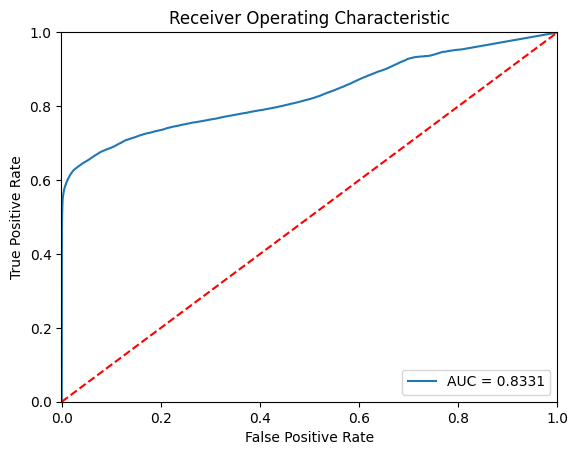

In [257]:
fpr, tpr, thresholds = roc_curve(validation_results_df.validation_true_label, 
                                 validation_results_df.validation_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

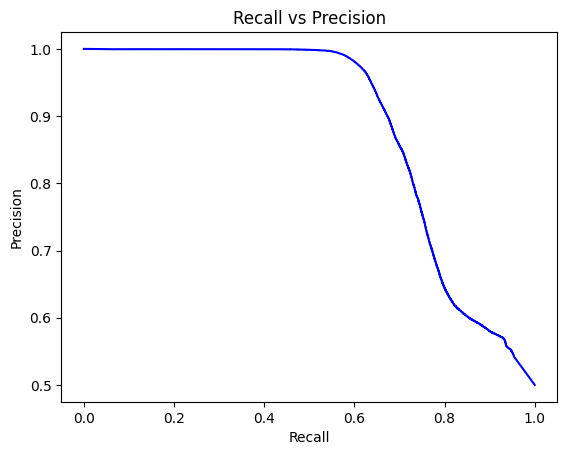

In [258]:
precision, recall, thresholds = precision_recall_curve(validation_results_df.validation_true_label, 
                                 validation_results_df.validation_pred)

plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [259]:
class_names = ["Normal", "Fraud"]
cr = classification_report(validation_results_df.validation_true_label, 
                                 validation_results_df.validation_pred.round(),
                      target_names=class_names,
                      output_dict=True) 
print(cr)

{'Normal': {'precision': 0.7164787913479698, 'recall': 0.9846385411569408, 'f1-score': 0.8294226605097701, 'support': 161443}, 'Fraud': {'precision': 0.9754501628406538, 'recall': 0.6103640294097608, 'f1-score': 0.7508820324466019, 'support': 161443}, 'accuracy': 0.7975012852833507, 'macro avg': {'precision': 0.8459644770943118, 'recall': 0.7975012852833507, 'f1-score': 0.790152346478186, 'support': 322886}, 'weighted avg': {'precision': 0.8459644770943117, 'recall': 0.7975012852833507, 'f1-score': 0.790152346478186, 'support': 322886}}


In [260]:
cr["Normal"]

{'precision': 0.7164787913479698,
 'recall': 0.9846385411569408,
 'f1-score': 0.8294226605097701,
 'support': 161443}

In [261]:
cr["Fraud"]

{'precision': 0.9754501628406538,
 'recall': 0.6103640294097608,
 'f1-score': 0.7508820324466019,
 'support': 161443}

In [262]:
confusion_matrix(validation_results_df.validation_true_label, 
                                 validation_results_df.validation_pred.round())

array([[158963,   2480],
       [ 62904,  98539]])

In [288]:
f1_score(validation_results_df.validation_true_label, 
                                 validation_results_df.validation_pred.round())

0.7508820324466019

In [289]:
precision_score(validation_results_df.validation_true_label, 
                                 validation_results_df.validation_pred.round())

0.9754501628406538

In [290]:
recall_score(validation_results_df.validation_true_label, 
                                 validation_results_df.validation_pred.round())

0.6103640294097608

## Test data

In [265]:
# Store results for plotting 
test_results = {}
test_results['test_loss'] = []
test_results['test_pred'] = []
test_results['test_true_label'] = []

# Evaluate accuracy on validation data 
curr_model.eval()

with torch.no_grad():
    for data, label in test_loader:
        # move data and label to device
        data = data.to(device)
        label = label.to(device)

        output = curr_model(data).to(device)
        #print(f"Output: {output}")

        # store relevant values 
        curr_loss = criterion(output, label).item()
        curr_label = label.item()
        curr_output = output.item()
        print(f"Loss: {loss}")
        test_results['test_loss'].append(curr_loss)
        test_results['test_true_label'].append(curr_label)
        test_results['test_pred'].append(curr_output)

        # accuracy
        acc = (output.round() == label).float().mean()
        acc = float(acc)
        #print(f"Accuracy: {acc}")
        accuracy["validation_accuracy"].append(acc) 

Streaming output truncated to the last 5000 lines.
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290923312306404
Loss: 0.03290

In [266]:
test_results_df = pd.DataFrame(test_results)

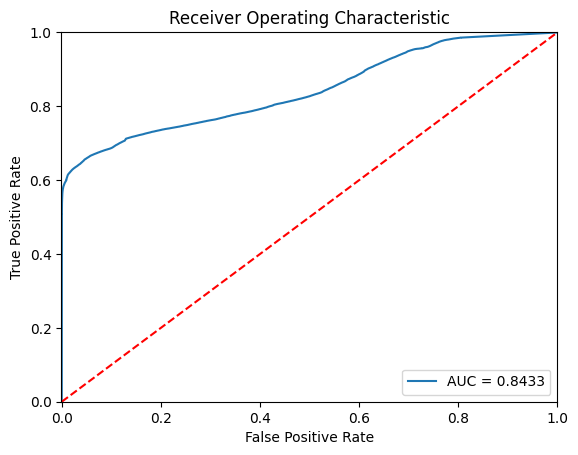

In [267]:
fpr, tpr, thresholds = roc_curve(test_results_df.test_true_label, 
                                 test_results_df.test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

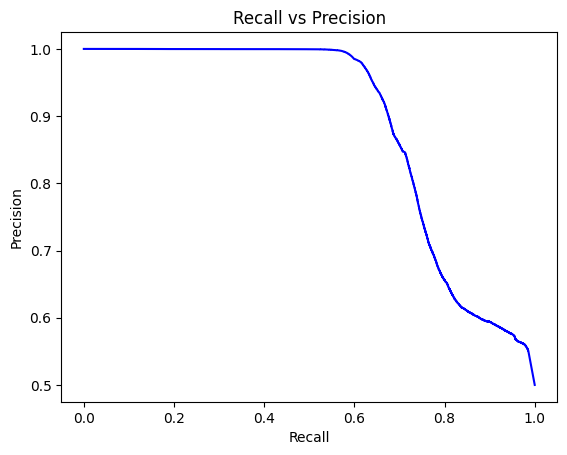

In [279]:
precision, recall, thresholds = precision_recall_curve(test_results_df.test_true_label, 
                                 test_results_df.test_pred)

plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [271]:
class_names = ["Normal", "Fraud"]
cr = classification_report(test_results_df.test_true_label, 
                                 test_results_df.test_pred.round(),
                      target_names=class_names,
                      output_dict=True) 

In [273]:
cr["Normal"]

{'precision': 0.7211064026086209,
 'recall': 0.9850006795408774,
 'f1-score': 0.8326444500727178,
 'support': 161874}

In [274]:
cr["Fraud"]

{'precision': 0.9763433526574755,
 'recall': 0.6190432064445186,
 'f1-score': 0.75768310341047,
 'support': 161874}

In [275]:
confusion_matrix(test_results_df.test_true_label, 
                                 test_results_df.test_pred.round())

array([[159446,   2428],
       [ 61667, 100207]])